# Range + flop interaction counter

This program is used for analysing how a given card range interacts with a selection of flops. It accepts a user's card range (depending on their position at the Poker table) in the regularly used format (e.g. "100: A9o-A2o" means 100% frequency on Ace 2 off-suited up to Ace 9 off-suited“), creates a list (a “range”) of all the possible hands the player could have (e.g. “Ah2d, Ah2s, Ah2c, etc.”). This “range” is then set against a representative sample of all possible flops that could occur in the game of Poker. The program counts the number card combinations two-pair or higher (two-pair, three of a kind, straight, flush, full house, four of a kind, straight flush, royal flush) that could theoretically occur given the user specified range.
This can be used for all sorts of  interesting data analysis in Poker. One can select a certain subset of possible flops (e.g. monotone flops or flops with paired cards) and then analyse the how different ranges interact with this flop. This then gives one a better idea of which range (determined by position on Poker table) is most suited to a given profile of flop.

A sample of the output data:

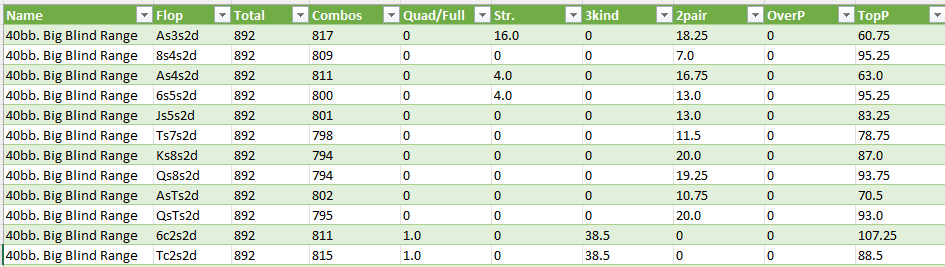

## Range generation functions


In [6]:
import re

def gen_usr_range_dict(c_lst):
    #formatting
    usr_range = c_lst.replace(" ", "") 
    c_lst = usr_range.split(",")
    if ":" not in c_lst[0]:
        c_lst[0] = "100:"+c_lst[0]
    
    #make a dictionary with weights (combo:weight)
    simp_combo_dict = dict()
    for freqs in c_lst:
        if ":" in freqs:
            f = int(freqs[:freqs.find(":")])
            n = freqs[freqs.find(":")+1:]
            simp_combo_dict[n]=f
        else:
            simp_combo_dict[freqs]=f
    #add combos to dictionary
    combo_dict = dict()
    for c, f in simp_combo_dict.items(): #add stuffing
        combo_dict.update(add_stuffing(c,f))
    
    #add suits to combos in new dictionary
    combo_dict_suited = dict()
    for c, f in combo_dict.items():
        combo_dict_suited.update(add_suits(c,f))

    return combo_dict_suited

def add_stuffing(combo, freq):
    combo_dict = dict()
    if len(combo) <= 3 and combo[-1] != '+': # singles
        combo_dict[combo]=freq
    elif combo[0] == combo[1] and combo[-1] != '+': #from one pair to another
        lst = combo.split("-")
        i, j = rank_to_num[lst[0][1]], rank_to_num[lst[1][-1]]
        if i > j:
            i,j = j,i
        while i <= j:
            combo_dict[num_to_rank[i]+num_to_rank[i]]= freq
            i += 1
    elif combo[0] == combo[1] and combo[-1] == '+': #pairs
        i = rank_to_num[combo[0]]
        while i < 15:
            a = num_to_rank[i] + num_to_rank[i]
            combo_dict[a]=freq
            i += 1
    elif combo[3] == "-": #from one combo to another
        lst = combo.split("-")
        i, j = rank_to_num[lst[0][1]], rank_to_num[lst[1][1]]
        if i > j:
            i,j = j,i
        while i <= j:
            a = combo[0] + num_to_rank[i] + combo[2]
            if not a[0] == a[1]:
                combo_dict[a]=freq
            i += 1  
    elif combo[-1] == '+': #combos plus
        i = rank_to_num[combo[1]]
        while i < rank_to_num[combo[0]]:
            a = combo[0] + num_to_rank[i] + combo[2]
            if a[0] != a[1]:
                combo_dict[a]=freq
            i += 1
            
    return combo_dict
            
def add_suits(c,freq):
    combo_dict = dict()
    if c[0] == c[1]:
        s = f"{c[0]}d{c[0]}h,{c[0]}d{c[0]}s,{c[0]}d{c[0]}c,{c[0]}h{c[0]}s,{c[0]}h{c[0]}c,{c[0]}s{c[0]}c".split(",")
    elif c[-1] == "s":
        s = f"{c[0]}d{c[1]}d,{c[0]}h{c[1]}h,{c[0]}s{c[1]}s,{c[0]}c{c[1]}c".split(",")
    elif c[-1] == "o":
        s = f"{c[0]}d{c[1]}h,{c[0]}d{c[1]}s,{c[0]}d{c[1]}c,{c[0]}h{c[1]}d,{c[0]}h{c[1]}s,{c[0]}h{c[1]}c,{c[0]}s{c[1]}d,{c[0]}s{c[1]}h,{c[0]}s{c[1]}c,{c[0]}c{c[1]}d,{c[0]}c{c[1]}h,{c[0]}c{c[1]}s".split(",")
    
    for h in s:
        combo_dict[h] = freq
        
    return combo_dict

def get_flop_list(flop_str):
    flop_lst = flop_str.split(",")
    
    #map numeric values to cards
    num_to_rank = {2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'T', 11: 'J', 12: 'Q', 13: 'K', 14: 'A'}
    rank_to_num = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}

    #Sets a sample of (representative) sample of flops. This string contains 184 sample flops
    lst = []
    for f in flop_lst:
        lst.append([f[:2],f[2:4],f[4:]])

    flop_lst = lst
    
    return flop_lst

## Count combos functions

In [7]:
def remove_cards(f,range_dict):
    lst = []
    red_range_dict = dict()
    for c in range_dict:
        if f[0] in c:
            continue
        elif f[1] in c:
            continue
        elif f[2] in c:
            continue
        else:
            red_range_dict[c] = range_dict[c]
    return red_range_dict

def count_flush(f):
    suit,i = f[0][1],0
    for c in range_dict.copy():
        if c[1] == suit and c[3] == suit:
            i += range_dict[c]*0.01
            range_dict.pop(c)
    return i

def count_trips_board(f,s,t):
    quads = 0
    full_house = 0 
    for c in range_dict:
        if c[0] == c[2]: #full house
            full_house += range_dict[c]*0.01
        if c[0] == f or c[2] == f: #quads
            quads += range_dict[c]*0.01
    return quads,full_house
    
def count_paired(flop):
    quads = 0
    trips = 0
    full_house = 0
    mid_pairs = 0
    
    f = flop[1:]+flop[0] if flop[1] == flop[2] else flop
    
    for c in range_dict: #count trips and full houses
        if f[0] in c:
            if c[0] == c[2]:
                quads += range_dict[c]*0.01 
            elif f[2] == c[0] and f[2] == c[2]:
                full_house += range_dict[c]*0.01               
            elif f[0] in c and f[2] in c: 
                full_house += range_dict[c]*0.01
            else:
                trips += range_dict[c]*0.01
        elif f[2] == c[0] and f[2] == c[2]:
            full_house += range_dict[c]*0.01
        elif f[2] == c[0] or f[2] == c[2]:
            if rank_to_num[f[2]] < rank_to_num[f[0]]:
                mid_pairs += range_dict[c]*0.01

    return quads,full_house,trips,mid_pairs
    
def count_other(flop):
    count_sets = 0
    count_2p = 0
    for c in range_dict:       
        #count sets
        if c[0] == c[2]:
            if c[0] in flop: #sets
                count_sets += range_dict[c]*0.01
        elif c[0] in flop and c[2] in flop: #two pair
            count_2p += range_dict[c]*0.01
    return count_sets,count_2p

def count_str_4_8(r):
    if len(r) == 5 and r[0]+2 == r[1] and r[0]+3 == r[2] and r[0]+4 == r[3] and r[0]+6 == r[4]:
        return 8 #8 out straight draw
    
    for i in range(2):
        for hand,diff in zip(r[i+1:],[1,2,3]):
            if r[i] + diff == hand:
                if diff == 3:
                    if r[0] == 1 and r[1] == 2 or r[-2] == 13 and r[-1] == 14:
                        return 4 #4 out straight draw
                    else:
                        return 8 #8 out straight draw
            else:
                break
                
def accommodate_aces(ranknum_no_d):
    if ranknum_no_d[-1] == 14:
        joined = "".join(str(x) for x in ranknum_no_d)
        for h in ['234','235','245','345']:
            if h in joined:
                ranknum_no_d = [1] + ranknum_no_d[:-1]
                break
    return ranknum_no_d

def count_guts(ranknum_no_d):
    if len(ranknum_no_d) == 5:
        loops = 2
    else:
        loops = 1
    for i in range(loops):
        for f in [ranknum_no_d[i:i+4]]: #check for gut shots
            if f[0]+1 == f[1] and f[0]+2 == f[2] and f[0]+4 == f[3]: #check for ccx
                return 0.01
            elif f[0]+1 == f[1] and f[0]+3 == f[2] and f[0]+4 == f[3]: #check for cxc
                return 0.01
            elif f[0]+2 == f[1] and f[0]+3 == f[2] and f[0]+4 == f[3]: #check for xcc
                return 0.01
    return 0

def count_straights(flop):
    i = 0
    straights , str_draw_4 , str_draw_8 = 0 , 0 , 0
    for c in range_dict:
        five_joined = flop + c[0] + c[2]
        
        ranknum = list(map(rank_to_num.get, list(five_joined)))
        ranknum.sort()
        
        #remove duplicates
        ranknum_no_d = []
        [ranknum_no_d.append(x) for x in ranknum if x not in ranknum_no_d]
        
        #skip when too few
        if len(ranknum_no_d) < 4:
            continue

        #Accommodating Aces
        ranknum_no_d = accommodate_aces(ranknum_no_d)

        #Check for straights
        if len(ranknum_no_d) == 5 and ranknum_no_d[0]+4 == ranknum_no_d[-1]:
            straights += range_dict[c]*0.01
            continue
      
        ###Check for 4/8 out straight draw. Loop through for consecutive numbers 
        #until that happens 3 times, otherwise break. Start on zero position 
        #and then first position

        if count_str_4_8(ranknum_no_d ) == 8:
            str_draw_8 += range_dict[c]*0.01
            continue
        elif count_str_4_8(ranknum_no_d) == 4:
            str_draw_4 += range_dict[c]*0.01
            continue
        #Count gut shots
        str_draw_4 += range_dict[c]*count_guts(ranknum_no_d)

    return straights , str_draw_4 , str_draw_8

def count_flush_draws(flop_joined):
    f = flop_joined[1]+flop_joined[3]+flop_joined[5]
    count = 0
    for c in range_dict:
        a = f+c[1]+c[3]
        for s in ["d","h","s","c"]:
            b = str(s)
            if a.count(b)==4:
                count += range_dict[c]*0.01
    return count

def count_over_pairs(flop):
    ranknum = list(map(rank_to_num.get, list(flop)))
    top = max(ranknum)
    count = 0
    for c in range_dict:
        if c[0] != c[2]:
            continue
        else:
            if rank_to_num[c[0]] > top:
                count += range_dict[c]*0.01
    return count

def count_top_pair(flop):
    ranknum = list(map(rank_to_num.get, list(flop)))
    top = max(ranknum)
    count = 0
    for c in range_dict:
        if rank_to_num[c[0]] != rank_to_num[c[2]]:
            if flop.count(c[0]) == 1 and rank_to_num[c[0]] == top and c[2] not in flop:
                count += range_dict[c]*0.01
            elif flop.count(c[2]) == 1 and rank_to_num[c[2]] == top and c[0] not in flop:
                count += range_dict[c]*0.01
    return count

def get_table(range_name,usr_range,flop_lst):
    results_lst = "Name,Flop,Total,Combos,Quad/Full,Str.,3kind,2pair,OverP,TopP\n"
    for flop in flop_lst:
        flop_joined = "".join(flop)
        
        #get dict with cards removed
        global range_dict
        num_combos_wo_rem = len(range_dict)
        
        #card removal
        range_dict = remove_cards(flop,mstr_range_dict)
        
        quadfull,straights,three_kind,two_pairs,over_pairs,top_pairs= 0,0,0,0,0,0

        #Count flushes on monotone
        #if flop[0][1] == flop[1][1] and flop[1][1] == flop[2][1]: #Monotone boards
        #    flushes = count_flush(flop,red_range_dict)

        f,s,t = flop[0][0],flop[1][0],flop[2][0]

        #Count made hands
        if f == s and s == t: #Trips boards
            a = count_trips_board(f,s,t)
            quadfull += a[0]
            quadfull += a[1]
        elif f == s or f == t or s == t: #Paired boards
            a = count_paired(f+s+t)
            quadfull += a[0] #quads
            quadfull += a[1] #full house
            three_kind += a[2]
        else:
            a = count_other(f+s+t)
            two_pairs += a[1]
            three_kind += a[0]
            
        over_pairs += count_over_pairs(f+s+t)
        top_pairs += count_top_pair(f+s+t)

        #Count draws and straights
        draws = count_straights(f+s+t)
        straights = draws[0]

        results_lst += f"{range_name},{flop_joined},{len(mstr_range_dict)},{len(range_dict)},{quadfull},{straights},{three_kind},{two_pairs},{over_pairs},{top_pairs}\n"
    return results_lst

### User input

In [10]:
### ------------------------------
#Sample list of flops. 184 flops which are said to represent all flops.
flops = "As3s2d,8s4s2d,As4s2d,6s5s2d,Js5s2d,Ts7s2d,Ks8s2d,Qs8s2d,AsTs2d,QsTs2d,6c2s2d,Tc2s2d,5c3d2s,6c3d2s,7c3d2s,7s3d2s,Ks3d2s,Qc3d2s,4s3s2s,9d3s2s,5c4d2s,9c4d2s,7d4s2s,6s5d2s,Js5d2s,Tc5d2s,Jc6d2s,8d6s2s,Qd6s2s,9s7d2s,As7d2s,Tc7d2s,Ac8d2s,Kc8d2s,Tc8d2s,Ts8s2s,QsJd2s,KdQs2s,QcTd2s,5s4s3d,8s5s3d,As6s3d,Js8s3d,AsJs3d,KsQs3d,8s3s3d,Jc3s3d,Ac4d3s,Jc4d3s,Ks4d3s,6s4s3s,Ac5d3s,Jd5s3s,Kc6d3s,9d6s3s,8c7d3s,8s7d3s,Ac7d3s,Qc7d3s,Ad7s3s,Js7s3s,9c8d3s,Tc9d3s,Qs9s3s,AsQs3s,AcTd3s,KdTs3s,As5s4d,Ts5s4d,8s6s4d,Qs7s4d,9s8s4d,Js9s4d,4s4d3c,Kc4s4d,Kc5d4s,Ks5d4s,Kd5s4s,7s6d4s,9c6d4s,Ac6d4s,Kc6d4s,Qc6d4s,Js6s4s,8c7d4s,Td7s4s,Jc8d4s,Qc8d4s,Qc9d4s,Js9s4s,QcJd4s,JcTd4s,AdTs4s,7s6s5d,8s6s5d,8s7s5d,9s7s5d,QsJs5d,7c5s5d,8s6d5s,Ac6d5s,Jc6d5s,Ks6s5s,9s7d5s,As7s5s,Qd7s5s,9c8d5s,As8s5s,Kc9d5s,Qs9d5s,Qd9s5s,Td9s5s,AdJs5s,AcTd5s,KsTd5s,QcTd5s,QdTs5s,AsTs6d,8s6s6d,9c6s6d,9s6s6d,Js6s6d,Ac7d6s,Tc7d6s,Kd7s6s,9c8d6s,Qs8d6s,Ts8d6s,Ts9d6s,As9s6s,KsJd6s,AcQd6s,KsQs6s,JcTd6s,AsKs7d,KsQs7d,Qc7s7d,Ts7s7d,Jc8d7s,Td8s7s,Jc9d7s,Ks9s7s,AsQd7s,AdQs7s,KdQs7s,AcTd7s,AsKs8d,8s8d3s,Tc8s8d,Ts9d8s,Ad9s8s,KcJd8s,AdKs8s,JsTd8s,JsTs9d,9s9d3c,9s9d3s,Ac9s9d,QcJd9s,AsKd9s,AdQs9s,KdQs9s,AdTs9s,AsAd5c,AsAdAc,AsAdJs,AsQsJd,JsJd4c,JsJd5c,JsJd7c,AdKsJs,KcQdJs,KsKd4s,KsKd6c,KsKd9c,AsKsKd,KsKdTc,AsKdQs,QsQd3c,QsQd8s,QsJsTd,KsJsTs,TsTd5c,TsTdTc"
#User specified range
usr_range = "100: A9s-A2s, KJs-K8s, K6s-K2s, Q9s+, Q7s-Q2s, J2s+, T2s+, 97s-92s, 82s+, 72s+, 62s+, 52s+, 42s+, 32s, A8o, A3o, KTo-K8o, K4o-K2o, QTo-Q7o, Q5o-Q2o, JTo, J6o-J4o, T6o, 96o+, 86o+, 75o+, 65o, 54o, 25: K7s, ATo, 50: 98s, A9o, KJo+, QJo, 75: Q8s, A7o-A4o, A2o, K7o-K5o, Q6o, J9o-J7o, T7o+"
#Name prefix for output file
range_name = '40bbBB_test'
new_file_name = range_name+'.csv'
### ------------------------------

flop_lst = get_flop_list(flops)
mstr_range_dict = gen_usr_range_dict(usr_range)
range_dict = mstr_range_dict
mstr = get_table(range_name,usr_range,flop_lst)

file = open(new_file_name,"a")
file.write(mstr)
file.close()